<a href="https://colab.research.google.com/github/iamsommyajain/Lung-Cancer-Detection/blob/main/Lung_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import matplotlib.pyplot as plt
import os
from os import path
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg16
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 99% 1.75G/1.76G [00:07<00:00, 329MB/s]
100% 1.76G/1.76G [00:07<00:00, 255MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip')
zip_ref.extractall('/content')
zip_ref.close()


In [6]:
DATADIR='/content/Lung Cancer'
CATEGORIES = ['lung_aca','lung_n','lung_scc']

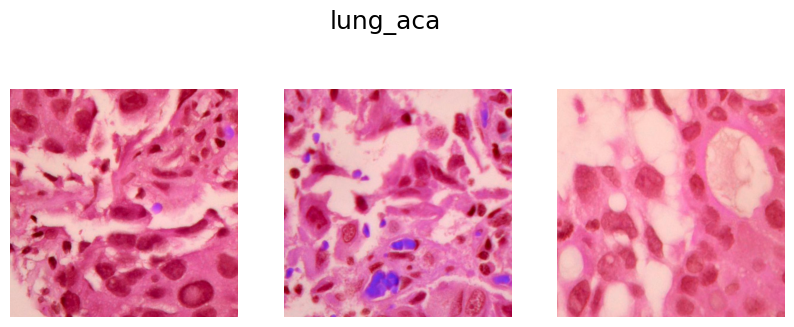

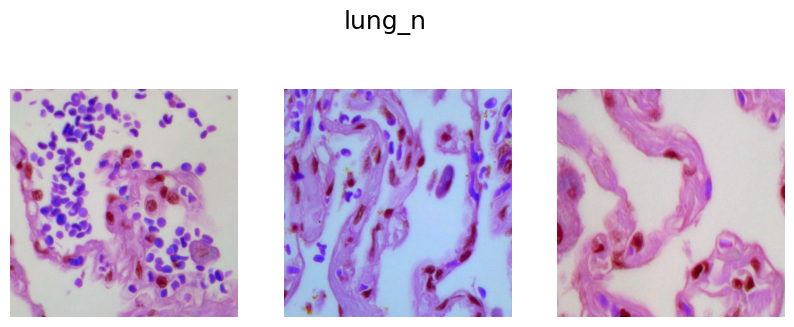

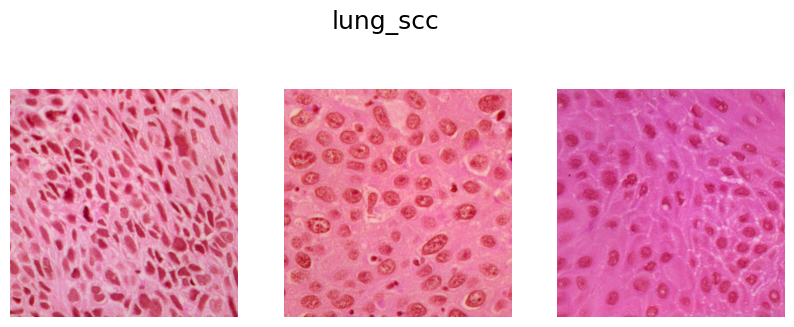

In [7]:
for category in CATEGORIES :
  path = os.path.join(DATADIR,category)
  images = os.listdir(path)
  fig,ax = plt.subplots(1,3, figsize =(10,4))
  fig.suptitle(f'{category}',fontsize=18)
  for i in range(3) :
    img_name=images[np.random.randint(0,len(images))]
    img_path = os.path.join(path,img_name)
    img_array = cv2.imread(img_path)
    ax[i].imshow(img_array)
    ax[i].axis('off')

In [8]:
img_array.shape

(768, 768, 3)

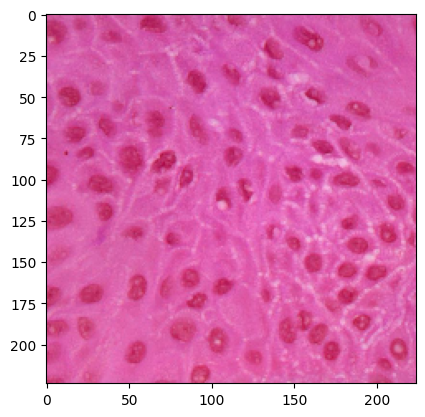

In [9]:
IMG_SIZE = 224
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array)

In [10]:
new_array.shape

(224, 224, 3)

Creating Training Data

In [11]:
training_data = []

def create_train_data() :
  for category in CATEGORIES :
    path = os.path.join(DATADIR,category)
    labels = CATEGORIES.index(category)
    for img in os.listdir(path) :
      try :
        img_array = cv2.imread(os.path.join(path,img))
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        training_data.append([new_array,labels])
      except Exception as e :
        pass
create_train_data()

In [12]:
len(training_data)

15000

In [13]:
X =[]
y = []
for features,labels in training_data :
  X.append(features)
  y.append(labels)

In [14]:
type(X), type(y)

(list, list)

In [15]:
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array(y)

In [16]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
print(f'X_train length :{X_train.shape[0]}, X_train Image size : {X_train.shape[1:3]}, X_train Channel Dimension : {X_train.shape[3]}')
print(f'X_test length :{X_test.shape[0]}, X_test Image size : {X_test.shape[1:3]}, X_test Channel Dimension : {X_test.shape[3]}')

X_train length :12000, X_train Image size : (224, 224), X_train Channel Dimension : 3
X_test length :3000, X_test Image size : (224, 224), X_test Channel Dimension : 3


VGG Model Building

In [19]:
vgg = vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
for layer in vgg.layers :
  layer.trainable = False

In [21]:
model = keras.Sequential([
    vgg,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(3,activation='softmax')
])

In [22]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
model.fit(X_train,y_train,epochs=5)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 155ms/step - accuracy: 0.8910 - loss: 0.8290
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 163ms/step - accuracy: 0.9751 - loss: 0.0669
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 165ms/step - accuracy: 0.9799 - loss: 0.0541
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - accuracy: 0.9881 - loss: 0.0300
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - accuracy: 0.9900 - loss: 0.0314


In [24]:
loss, accuracy = model.evaluate(X_test,y_test)
print(f'Model Accuracy : {accuracy*100} %')

94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.9839 - loss: 0.0425
Model Accuracy : 98.26666712760925 %


In [26]:
pred = np.argmax(model.predict(X_test), axis=-1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step


In [27]:
pred

array([2, 1, 2, ..., 2, 2, 2])

In [28]:
y_test[:5]

array([2, 1, 2, 0, 1])

In [29]:
pred[:5]

array([2, 1, 2, 0, 1])

In [31]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1037
           1       1.00      1.00      1.00       970
           2       0.97      0.98      0.98       993

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



Text(50.722222222222214, 0.5, 'Actual')

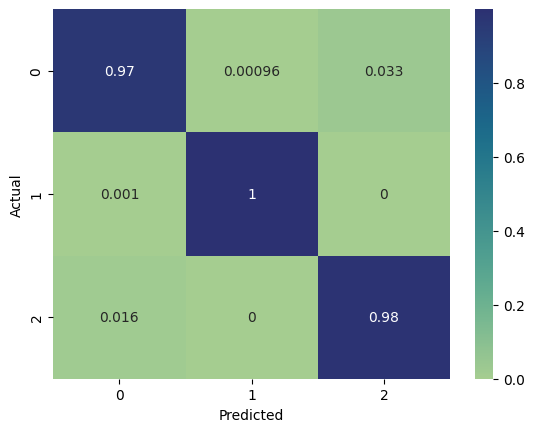

In [34]:
cf = confusion_matrix(y_test,pred,normalize='true')
sns.heatmap(cf,annot=True,cmap='crest')
plt.xlabel('Predicted')
plt.ylabel('Actual')